In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras import Input
from keras.layers import SimpleRNN, LSTM
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


ModuleNotFoundError: No module named 'tensorflow.compat'

<h1>Loading the dataset and data preparation</h1>
Dataset includes a lot of weather data and some other data, but for the start I'm going to use only date and amount of customers

In [ ]:
df = pd.read_csv("bike_sharing_dataset.csv")
# Leave only two columns
df = df[["total_cust", "date"]]
# Change data format to datetime
df["date"] = pd.to_datetime(df.date)
# Sort the dataset by date, reset the index
df = df.sort_values(by='date')
df = df.reset_index(drop=True)
# Define target variable for later usage
target = "total_cust"
df


,total_cust,date
0,959.0,2011-01-01
1,781.0,2011-01-02
2,1301.0,2011-01-03
3,1536.0,2011-01-04
4,1571.0,2011-01-05
...,...,...
2917,5430.0,2018-12-27
2918,2125.0,2018-12-28
2919,6008.0,2018-12-29
2920,4929.0,2018-12-30


Check if there are some dates missing

In [ ]:
df['Gap'] = df['date'].diff().dt.days
missing_rows = df[df['Gap'] > 1]
print(missing_rows[['date', 'Gap']])

Empty DataFrame
Columns: [date, Gap]
Index: []


Let's see how seasonal the data is and what is a pattern

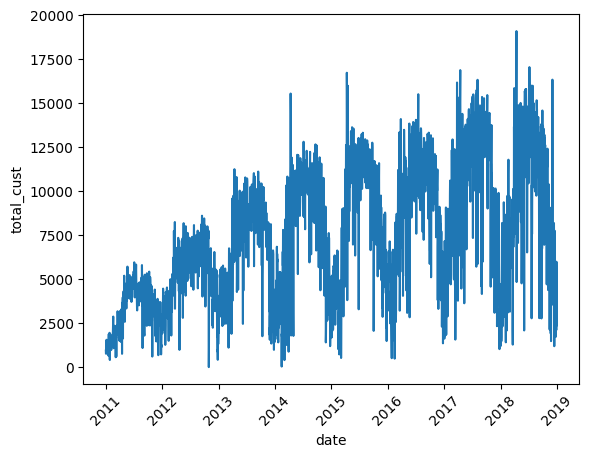

In [ ]:
ax = sns.lineplot(data=df, x='date', y='total_cust')
# Show only year ticks
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

plt.show()

Data is clearly seasonal, amount of customers grows starting at spring, highest peak is during the summer and then it goes slowly down during autumn with lowest on winter

In [ ]:
# Don't need date and gap anymore
df = df.drop(["date", "Gap"], axis=1)
# Turns out dataset have missing 4 days of data, so I will just drop them for now
df = df.dropna()

<h1>Scaling</h1>

In [ ]:
# Scale target variable
scaler = MinMaxScaler()
df[[target]] = scaler.fit_transform(df[[target]])

df.index = df.index * 0.1 + 1

In [ ]:
# let's figure out a good cutoff point for train/test
# 67% for training, 33% for testing
cutoff = int(len(df) * 0.67)

# train data
X_train = df.index[0:cutoff]
y_train = df[target].iloc[0:cutoff]

# test data 
X_test = df.index[cutoff:]
y_test = df[target].iloc[cutoff:]

# convert everything into NumPy -array format
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# number of variables is just 1
n_features = 1

# use reshape tools to get the data ready for future use
train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

In [ ]:
# the variable that determines how many points 
# back into the past the model attempts to learn
look_back  = 32
batch_size = 2

# using 1 => using time steps
# anything over 1 => uses windowing
window_size = 1

# create a separate generator training and testing data
train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = window_size,
                                      batch_size    = batch_size)

In [ ]:
n_neurons  = 16

model = Sequential()
model.add(SimpleRNN(n_neurons, activation="relu", input_shape=(look_back, n_features)))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# create a model checkpoint to a file, and only save the best one
mc = ModelCheckpoint('best_model_flights.keras', monitor='val_loss', mode='min', save_best_only=True)
callback_list = [mc]

model.fit(train_generator, epochs=100, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/100


/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/kirillsobolev/Documents/GitHub/Deep-Learning/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


962/962 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0074 - val_loss: 0.0189
Epoch 2/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0063 - val_loss: 0.0151
Epoch 3/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0064 - val_loss: 0.0155
Epoch 4/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0067 - val_loss: 0.0153
Epoch 5/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0059 - val_loss: 0.0155
Epoch 6/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - val_loss: 0.0154
Epoch 7/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0065 - val_loss: 0.0152
Epoch 8/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0062 - val_loss: 0.0156
Epoch 9/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0066 - val_loss: 0.0152
Epoch 10/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0060 - val_loss: 0.0156
Epoch 11/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0070 - val_loss: 0.0151
Epoch 12/100
962/962 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

<Axes: >

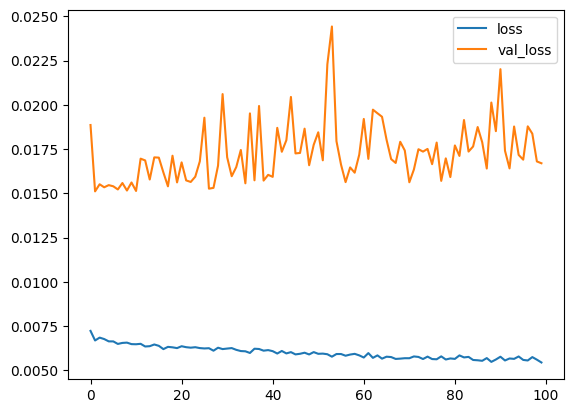

In [ ]:
 # the usual training metric visualization
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [ ]:
 # reload the best version of the model
model = load_model("best_model_flights.keras")

In [ ]:
test_predictions = model.predict(test_generator)

466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step


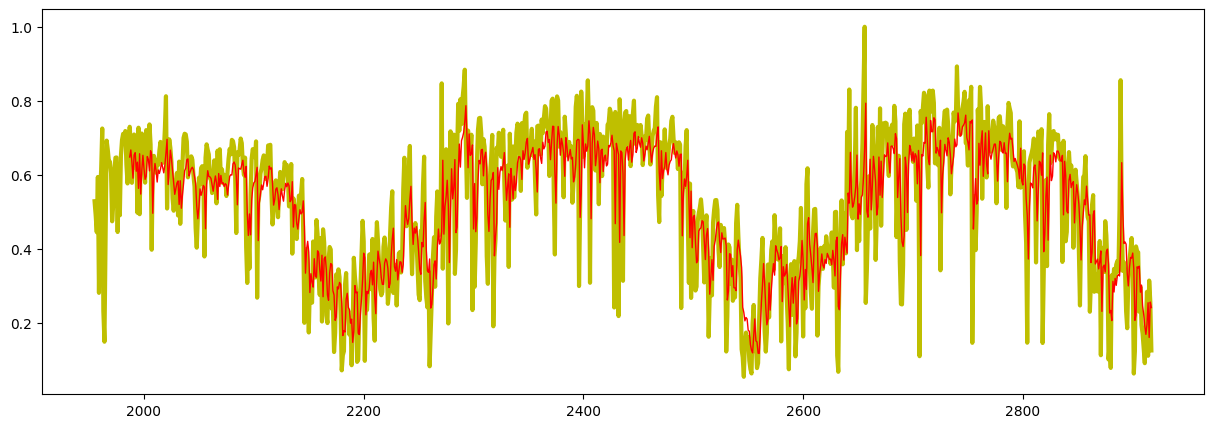

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()

In [ ]:
# TensorFlow evaluation metrics
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

# test loss
result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

# some difference here which we can see in the test-signal prediction already 

962/962 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - loss: 0.0035
Training loss: 0.006234417203813791
466/466 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - loss: 0.0119
Testing loss: 0.01511315256357193


In [ ]:
# let's make a separate copy of the test values
# so we can calculate some errors

actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = np.mean(errors / actual_y_test) * 100

# print out the MAPE-score
print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# the typical error metrics
# MAE = mean average error 
# MAPE score => less than 5% => very excellent result
# MAPE score => less than 10% => excellent result
# MAPE score => 10-20% => good result
# MAPE score => 20-50% => okay / reasonable / decent result

# negative MAPE score => the model constantly overestimates the values
# MAPE score over 100% => the model constantly underestimates the values

# MAPE results sometimes produce weird results with synthetic data
# since synthetic data is often extremely predictable
# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared. 0 = the model descibes the dataset poorly
# 1 = model describes the dataset perfectly
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

KeyboardInterrupt: 

In [ ]:
# EXTRAPOLATION TEST 1 - 180 new points
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

# extrapolate the next 180 values
for i in range(120):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
# ax.legend(loc="lower left")
plt.show()